In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression, GenericUnivariateSelect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from functools import partial
import pandas as pd
from chapter2.data import make_dataset
from chapter2 import conf

plt.set_loglevel("warning")

%reload_ext autoreload
%aimport chapter2.conf
%aimport chapter2.data.make_dataset
%autoreload 1

In [76]:
housing_train = make_dataset.load_data(
    conf.ROOT_DATA_DIR, conf.DataDirectory.INTERIM, "housing_train.csv"
)
housing_train = housing_train.drop("index", axis=1)
housing_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16353.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.576302,35.636741,28.698159,2638.437318,538.485844,1433.163578,501.021621,3.862962,206479.995942
std,1.999541,2.134570,12.583490,2206.989208,424.051052,1156.825167,385.699394,1.899589,115528.104253
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.940000,18.000000,1450.000000,296.000000,788.000000,280.000000,2.556800,119675.000000
50%,-118.505000,34.260000,29.000000,2126.000000,436.000000,1170.000000,410.000000,3.530750,178650.000000
75%,-118.010000,37.720000,37.000000,3148.000000,647.000000,1724.250000,606.000000,4.738700,263800.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Numerical and Categorical features

Let's separate numerical and categorical (in this case only ocean_proximity) features.

In [77]:
y_name = "median_house_value"
num_cols = [
    col
    for col in housing_train.drop(y_name, axis=1).columns
    if housing_train[col].dtype in ["int64", "float64"]
]
cat_cols = [
    col for col in housing_train.columns if housing_train[col].dtype == "object"
]
y = housing_train[y_name]

## Target variables


In [78]:
y.value_counts().sort_values(ascending=False).nlargest(5)

500001.0    796
137500.0    103
162500.0     92
112500.0     86
187500.0     73
Name: median_house_value, dtype: int64

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

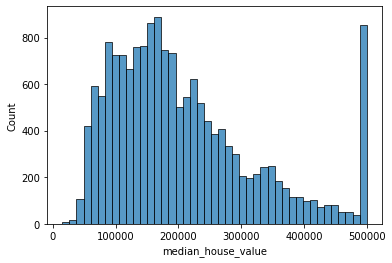

In [79]:
sns.histplot(y)

500k probably is a ceiling. Let's drop it for now.

In [80]:
housing_train_no_500k = housing_train.copy()[
    housing_train["median_house_value"] < 500000
]
print(f"{housing_train_no_500k.shape[0]-housing_train.shape[0]} records removed")

-817 records removed


## Identifying most promising variables

In [81]:
housing_train_no_500k.corr()[y_name].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.643052
total_rooms           0.145331
households            0.098328
total_bedrooms        0.079454
housing_median_age    0.064233
population            0.014009
longitude            -0.039936
latitude             -0.154607
Name: median_house_value, dtype: float64

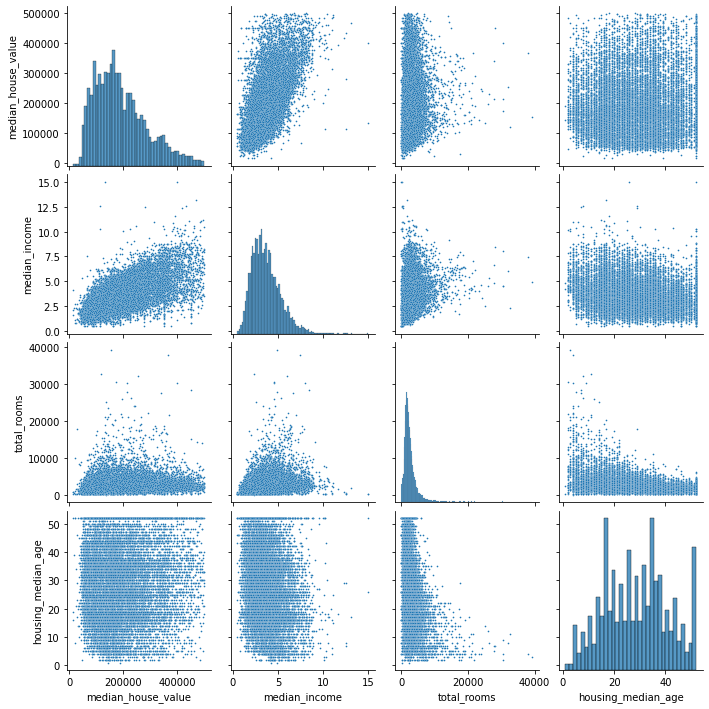

In [82]:
sns.pairplot(
    housing_train_no_500k[
        [y_name, "median_income", "total_rooms", "housing_median_age"]
    ],
    plot_kws={"s": 3},
)

## Geographic variables

We can get a map-like plot using latitude and longitude coordinates.

It is not so clear if correlation exists between the geographical location and median_house_value.

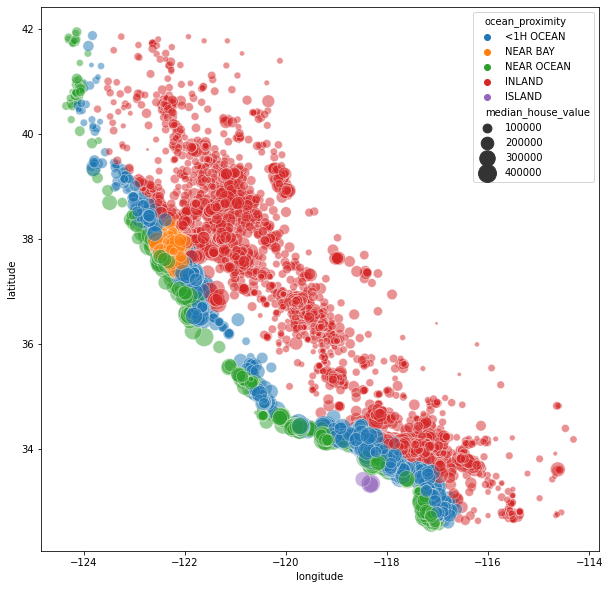

In [83]:
def map_plot(data):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        data=data,
        x="longitude",
        y="latitude",
        hue="ocean_proximity",
        size="median_house_value",
        sizes=(10, 400),
        alpha=0.5,
    )


map_plot(housing_train_no_500k)

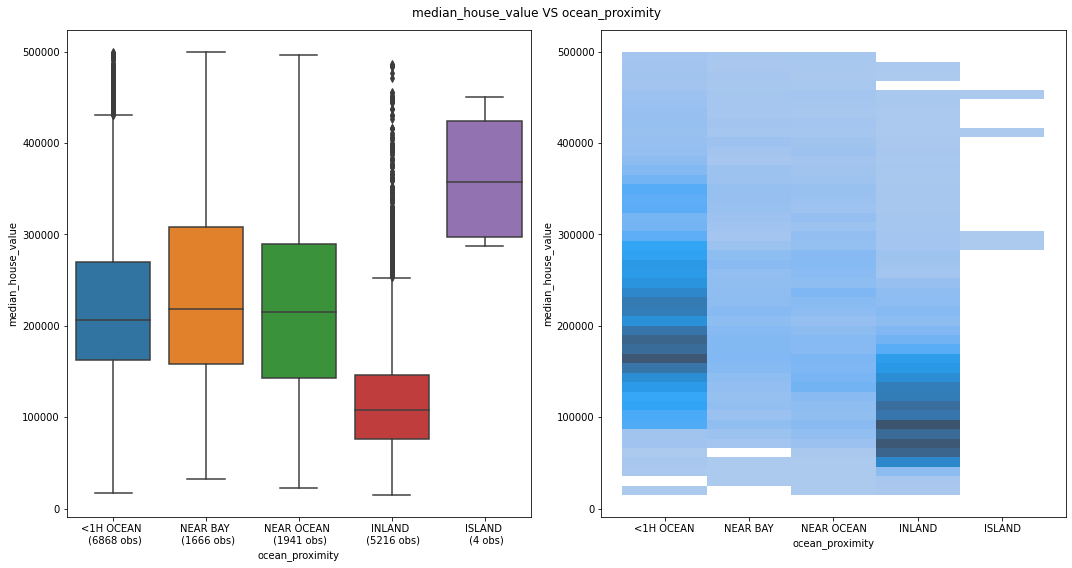

In [84]:
def median_house_value_vs_ocean_proximity(data, title):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
    ax0 = sns.boxplot(
        x="ocean_proximity", y="median_house_value", data=data, ax=ax.flat[0]
    )
    val_count = housing_train_no_500k["ocean_proximity"].value_counts()
    new_xticks = [
        f"{xtick.get_text()} \n ({val_count[xtick.get_text()]} obs)"
        for xtick in ax0.get_xticklabels()
    ]
    ax0.set_xticklabels(new_xticks)
    sns.histplot(x="ocean_proximity", y="median_house_value", data=data, ax=ax.flat[1])
    fig.suptitle(title)
    plt.tight_layout()


median_house_value_vs_ocean_proximity(
    housing_train_no_500k, title="median_house_value VS ocean_proximity"
)

## Missing values

Let's fix some missing values for `total_bedrooms` and check its repartition in regards to the target variable.

In [85]:
housing_train_no_500k.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        156
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

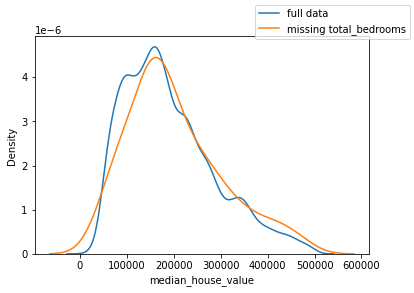

In [86]:
mask = housing_train_no_500k.isna()["total_bedrooms"]

fig, ax = plt.subplots(1, 1)
sns.kdeplot(housing_train_no_500k["median_house_value"], ax=ax)
sns.kdeplot(housing_train_no_500k.loc[mask, "median_house_value"], ax=ax)
fig.legend(["full data", "missing total_bedrooms"])

In [87]:
rooms_per_household = housing_train["total_rooms"] / housing_train["households"]
rooms_per_household_cutoff = np.percentile(rooms_per_household, 99.99)
rooms_per_household_mask = rooms_per_household < rooms_per_household_cutoff

bedrooms_room_ratio = housing_train["total_bedrooms"] / housing_train["total_bedrooms"]
bedrooms_room_ratio_cutoff = 1
bedrooms_room_ratio_mask = bedrooms_room_ratio < bedrooms_room_ratio_cutoff

bedrooms_room_ratio

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
16507    1.0
16508    1.0
16509    1.0
16510    1.0
16511    1.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [91]:
imputer = SimpleImputer(strategy="median")
housing_train_imputed = housing_train_no_500k.copy()
housing_train_imputed[num_cols] = imputer.fit_transform(housing_train_no_500k[num_cols])

## Rooms and bedrooms

Rooms and bedrooms information are given as total for each neighboorhood. Let's see if bringing these information to ratios is more relevant.

In [355]:
housing_train_imputed["rooms_per_household"] = (
    housing_train_imputed["total_rooms"] / housing_train_no_500k["households"]
)
housing_train_imputed["bedrooms_per_household"] = (
    housing_train_imputed["total_bedrooms"] / housing_train_no_500k["households"]
)
housing_train_imputed["bedrooms_room_ratio"] = (
    housing_train_imputed["total_bedrooms"] / housing_train_no_500k["total_bedrooms"]
)
housing_train_imputed.corr()["median_house_value"].abs().sort_values(ascending=False)

median_house_value        1.000000
median_income             0.643052
bedrooms_room_ratio       0.197608
latitude                  0.154607
total_rooms               0.145331
rooms_per_household       0.116504
households                0.098328
total_bedrooms            0.078724
housing_median_age        0.064233
bedrooms_per_household    0.049914
longitude                 0.039936
population                0.014009
Name: median_house_value, dtype: float64

The bedroom to room ratio seems interesting and the rooms per household seems also better than the total_rooms.

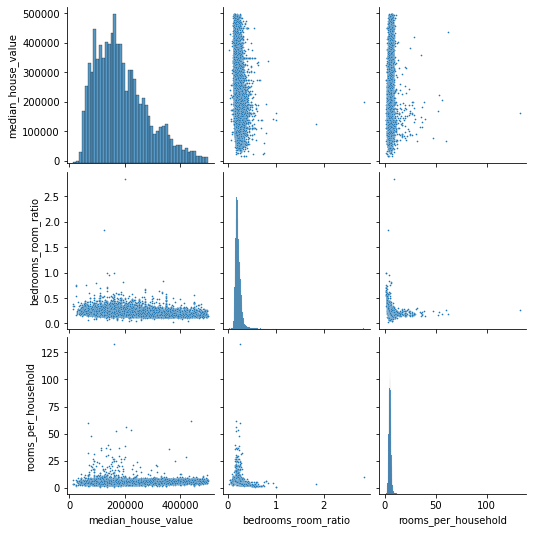

In [356]:
sns.pairplot(
    housing_train_imputed[
        [
            "median_house_value",
            "bedrooms_room_ratio",
            "rooms_per_household",
        ]
    ],
    plot_kws={"s": 3},
)

These two seems to be highly right skewed.

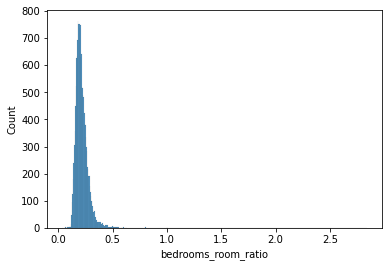

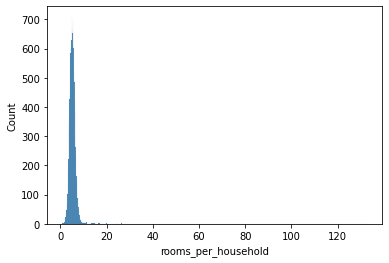

In [357]:
for col in ["bedrooms_room_ratio", "rooms_per_household"]:
    sns.histplot(housing_train_imputed[col])
    plt.show()

* bedrooms_room_ratio probably shouldn't be >= 1
* rooms_per_households is a bit trickier since their might be some very nice villas... let's have a closer look.

### bedrooms_room_ratio

Let's check what a cutoff=1 would mean

In [359]:
housing_train_imputed[housing_train_imputed["bedrooms_room_ratio"] >= 1]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,rooms_per_household,bedrooms_per_household,bedrooms_room_ratio
7298,-118.44,34.28,46.0,11.0,11.0,24.0,13.0,2.8750,<1H OCEAN,162500.0,0.846154,0.846154,1.000000
9510,-119.11,35.42,52.0,154.0,437.0,37.0,16.0,10.0263,INLAND,200000.0,9.625000,27.312500,2.837662
10404,-117.79,35.21,4.0,2.0,2.0,6.0,2.0,2.3750,INLAND,137500.0,1.000000,1.000000,1.000000
11605,-121.85,36.61,38.0,238.0,437.0,191.0,67.0,1.3897,<1H OCEAN,125000.0,3.552239,6.522388,1.836134


## Identifying most promising variables

Only 4 rows would be removed. Let's keep this as a cutoff.

### rooms_per_households

In [360]:
largest_rooms_per_households = pd.concat([housing_train_imputed, y], axis=1).nlargest(
    n=10, columns="rooms_per_household"
)
largest_rooms_per_households

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,rooms_per_household,bedrooms_per_household,bedrooms_room_ratio,median_house_value
10627,-120.08,38.80,34.0,1988.0,511.0,36.0,15.0,4.6250,INLAND,162500.0,132.533333,34.066667,0.257042,162500.0
2946,-120.06,39.01,19.0,2967.0,528.0,112.0,48.0,4.0714,INLAND,437500.0,61.812500,11.000000,0.177958,437500.0
7266,-121.25,40.27,25.0,958.0,245.0,28.0,16.0,2.6250,INLAND,67500.0,59.875000,15.312500,0.255741,67500.0
11401,-120.16,39.01,16.0,1463.0,264.0,54.0,26.0,4.9750,INLAND,206300.0,56.269231,10.153846,0.180451,206300.0
11597,-119.02,37.64,14.0,5919.0,1278.0,265.0,112.0,3.2431,INLAND,221400.0,52.848214,11.410714,0.215915,221400.0
1810,-120.06,39.15,22.0,2213.0,372.0,98.0,42.0,1.1912,INLAND,170000.0,52.690476,8.857143,0.168098,170000.0
11584,-120.19,38.42,11.0,1568.0,369.0,82.0,33.0,3.1250,INLAND,77500.0,47.515152,11.181818,0.235332,77500.0
10697,-120.18,39.28,14.0,10098.0,1545.0,701.0,254.0,4.0819,INLAND,141300.0,39.755906,6.082677,0.153001,141300.0
9107,-119.93,38.94,27.0,1709.0,408.0,97.0,44.0,2.4917,INLAND,200000.0,38.840909,9.272727,0.238736,200000.0
2588,-120.03,38.19,26.0,7005.0,1358.0,416.0,189.0,2.1250,INLAND,132500.0,37.063492,7.185185,0.193862,132500.0


The largest rooms_per_household sits at 142, but with a median_house_value at the ceiling of 500k, with very few households and population. On the otherhand the second to largest 133 rooms_per_households had an unimpressive median_house_value of 162k.

We check if this comes from the imputed values of total_bedrooms, which it doesn't seem to be.

In [361]:
largest_rooms_per_households.index.isin(
    housing_train_imputed[housing_train.isna().any(axis=1)]
).sum()

/tmp/ipykernel_15500/217316303.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  largest_rooms_per_households.index.isin(housing_train_imputed[housing_train.isna().any(axis=1)]).sum()


0

Let's check a 99.99 percentile, because why not.

In [362]:
(
    housing_train_imputed[["rooms_per_household"]]
    > np.percentile(housing_train_imputed[["rooms_per_household"]], 99.99)
).sum()

rooms_per_household    2
dtype: int64

If we want to be conservative we can keep the 99.99 pecentile as a cutoff.

### Dropping outliers

In [363]:
rooms_per_household_cutoff = np.percentile(
    housing_train_imputed[["rooms_per_household"]], 99.99
)
bedrooms_room_ratio_cutoff = 1
query = f"rooms_per_household<{rooms_per_household_cutoff} and bedrooms_room_ratio<{bedrooms_room_ratio_cutoff}"
housing_train_outliers_dropped = housing_train_imputed.query(query)
print(
    f"{housing_train_outliers_dropped.shape[0]-housing_train_imputed.shape[0]} records removed"
)

-6 records removed


## Zero value data

In [364]:
housing_train_outliers_dropped[
    (housing_train_outliers_dropped[num_cols] == 0).any(axis=1)
]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,rooms_per_household,bedrooms_per_household,bedrooms_room_ratio


No zero value in numercical columns.